In [52]:
import os
import sys
import time
import openpyxl

import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

import torch
import torchvision

import torchvision.utils as vutils
import torchvision.transforms as transforms

from torch import nn, optim, autograd
from dataclasses import dataclass

%matplotlib inline
torch.set_num_threads(1)
torch.manual_seed(1)

In [ ]:
device = 'cpu'

In [53]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode


# Class for a customized dataset
# In this case preprocessed CEM images combined in a 3-channel RGB .jpg format
# and the corresponding mask of present lesions in a 1-channel .png format
class CustomImageDataset(Dataset):
    def __init__(self, root, cases_file, view, width=256, height=256):
        
        self.wb = openpyxl.load_workbook(os.path.join(root, cases_file))['AllCases']        
        self.root = root        
        self.view = view
        self.width = width
        self.height = height

    def __len__(self):
        
        # Return the number of cases in the dataset
        # In this set, CC and MLO of the same breast are considered different cases
        
        list_all = []
        for cell_obj in self.wb['A'][1:] :
            list_all.append(cell_obj.value)
        
        return len(list_all)

    def __getitem__(self, idx):
        
        casedir = self.wb['A'][idx+1].value
        print(casedir)
        
        # Collect the mask, low-energy image and recombined image of a CEM case
        for filename in os.listdir(os.path.join(casedir, self.view)) :
            
            if "LOW" in filename and not "mask" in filename :
                le_image = pydicom.dcmread(os.path.join(casedir, self.view, filename))
                le_array = le_image.pixel_array.astype(np.int32)
                le_array = (le_array-np.amin(le_array))/(np.amax(le_array)-np.amin(le_array))
        
            elif "mask" in filename :
                mask = pydicom.dcmread(os.path.join(casedir,self.view,filename), force=True)
                mask_array = list(mask[0x4d4d,0x2a00].value)[-le_array.size:]
                mask_array = np.array(mask_array).astype(np.int32)
                mask_array = np.reshape(mask_array, (le_array.shape[0],le_array.shape[1]))
                mask_array[mask_array > 0] = 65535
                
            elif "REC" in filename :
                rc_image = pydicom.dcmread(os.path.join(casedir, self.view, filename))
                rc_array = rc_image.pixel_array.astype(np.int32)
                rc_array = (rc_array-np.amin(rc_array))/(np.amax(rc_array)-np.amin(rc_array))

        
        # Concatenate 3 arrays in multi-channel image
        combined_img = np.stack((le_array,rc_array,mask_array), axis=0)
        combined_img = torch.from_numpy(combined_img).type(torch.FloatTensor)
#         print('combined', combined_img.shape)
        
        # Find nonzero region in mask
        mask_nz = np.nonzero(mask_array)
        xmin = min(mask_nz[0])
        xmax = max(mask_nz[0])
        ymin = min(mask_nz[1])
        ymax = max(mask_nz[1])
        # Define bounding box of nonzero region
        boxes = [[ymin, xmin, ymax, xmax]]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        xmiddle = (xmin+xmax)/2
        ymiddle = (ymin+ymax)/2
        xdist = xmax-xmin
        ydist = ymax-ymin
        # Get patch around nonzero region
        # If nonzero region is smaller than allowed size, surrounding tissue is saved as well
        cropped_region = combined_img[:,
                                      int(max(0,xmiddle-max(self.width/2,xdist/2))):min(le_array.shape[0],int(xmiddle+max(self.width/2,xdist/2))),
                                      int(max(0,ymiddle-max(self.height/2,ydist/2))):min(le_array.shape[1],int(ymiddle+max(self.height/2,ydist/2)))]   
#         print('cropped', cropped_region.shape)
        # If nonzero region is larger than allowed size,
        # the patch equals the bounding box and is then resized to the allowed size
        resized_region = T.functional.resize(cropped_region, (self.height,self.width))
#         print('resized', resized_region.shape)
        
#         boxes_region = [[max(0,self.height/2-ydist/2)*(self.height/cropped_region.shape[2]),
#                          max(0,self.width/2-xdist)*(self.width/cropped_region.shape[1]),
#                          min(self.height,self.height/2+ydist/2)*(self.height/cropped_region.shape[2]),
#                          min(self.width,self.width/2+xdist/2)*(self.width/cropped_region.shape[1])]]

        boxes_region = [[max(0,self.height/2-ydist/2),
                         max(0,self.width/2-xdist),
                         min(self.height,self.height/2+ydist/2),
                         min(self.width,self.width/2+xdist/2)]]
        
        boxes_region = torch.as_tensor(boxes_region, dtype=torch.float32)
        area_region = (boxes_region[:,3]-boxes_region[:,1]) * (boxes_region[:,2]-boxes_region[:,0])
        
        # Save label of benign and malignant cases
        labels = self.wb['F'][idx+1].value
        if 'ben' in labels :
            labels = 0
        elif 'mal' in labels :
            labels = 1
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["image_id"] = torch.tensor([idx+1])
        target["boxes"] = boxes
        target["boxes_region"] = boxes_region
        
        target["area"] = area
        target["area_region"] = area_region
        target["labels"] = labels
            
        return combined_img, resized_region, target


In [5]:
inputdir = r'D:\syntheticCasesReady'
traintrue_data = CustomImageDataset(inputdir, '220414_CEmammo_classification_simulationsAstrid.xlsx', 'CC')

In [34]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import utils
from torch.utils.data import random_split

train_data, true_data = random_split(traintrue_data, [int(np.floor(len(traintrue_data)*0.5)), int(np.ceil(len(traintrue_data)*0.5))], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=False, collate_fn=utils.collate_fn, drop_last=True)
true_dataloader = DataLoader(true_data, batch_size=4, shuffle=False, collate_fn=utils.collate_fn, drop_last=True)

In [35]:
len(train_dataloader), len(true_dataloader)

(24, 24)

D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
tensor([159]) tensor([[1640.,  910., 1691.,  962.]]) tensor([[102.5000,  76.0000, 153.5000, 154.0000]])
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
[860, 1012, 1590, 1741]
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_R
[26, 204, 52, 203]
D:\syntheticCasesReady\new220318\MUMC_0975_R
D:\syntheticCasesReady\new220318\MUMC_0975_

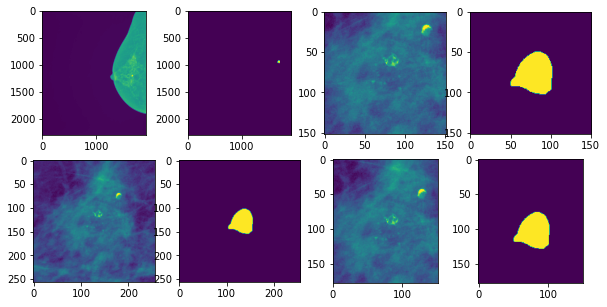

In [8]:
import matplotlib.pyplot as plt
pat_idx = 0
print(train_data[pat_idx][2]['image_id'], train_data[pat_idx][2]['boxes'], train_data[pat_idx][2]['boxes_region'])

fig, ax = plt.subplots(2,4, figsize=(10,5))

ax[0][0].imshow(train_data[pat_idx][0][0])
ax[0][1].imshow(train_data[pat_idx][0][2])

enlarged_box = [int(train_data[pat_idx][2]['boxes'][0][1])-50,
                int(train_data[pat_idx][2]['boxes'][0][3])+50,
                int(train_data[pat_idx][2]['boxes'][0][0])-50,                
                int(train_data[pat_idx][2]['boxes'][0][2])+50]
print(enlarged_box)
ax[0][2].imshow(train_data[pat_idx][0][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])
ax[0][3].imshow(train_data[pat_idx][0][2, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])


ax[1][0].imshow(train_data[pat_idx][1][0])
ax[1][1].imshow(train_data[pat_idx][1][2])

enlarged_box = [int(train_data[pat_idx][2]['boxes_region'][0][1])-50,
                int(train_data[pat_idx][2]['boxes_region'][0][3])+50,
                int(train_data[pat_idx][2]['boxes_region'][0][0])-50,                
                int(train_data[pat_idx][2]['boxes_region'][0][2])+50]
print(enlarged_box)
ax[1][2].imshow(train_data[pat_idx][1][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])
ax[1][3].imshow(train_data[pat_idx][1][2, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])

In [9]:
# custom weights initialization called on generator and discriminator
def init_weights(net, init_type='normal', scaling=0.02):
    
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
            
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


In [10]:
## From https://learnopencv.com/paired-image-to-image-translation-pix2pix/ and from MediGAN

import torch.nn as nn

class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        print('input_nc,output_nc,num_downs', input_nc,output_nc,num_downs)
        
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

                
    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        
#         if type(norm_layer) == functools.partial:
#             use_bias = norm_layer.func == nn.InstanceNorm2d
#         else:
#             use_bias = norm_layer == nn.InstanceNorm2d
            
        use_bias = False
            
        if input_nc is None:
            input_nc = outer_nc
            
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc*2, outer_nc, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
            
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
            
        else:
            upconv = nn.ConvTranspose2d(inner_nc*2, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

        
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
#         if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
#             use_bias = norm_layer.func == nn.InstanceNorm2d
#         else:
#             use_bias = norm_layer == nn.InstanceNorm2d
            
        use_bias = False

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc,ndf,kernel_size=kw,stride=2,padding=padw), nn.LeakyReLU(0.2,True)]
        nf_mult = 1
        nf_mult_prev = 1
        
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [nn.Conv2d(ndf*nf_mult_prev, ndf*nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                         norm_layer(ndf*nf_mult),
                         nn.LeakyReLU(0.2, True)]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [nn.Conv2d(ndf*nf_mult_prev, ndf*nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
                     norm_layer(ndf*nf_mult),
                     nn.LeakyReLU(0.2, True)]

        sequence += [nn.Conv2d(ndf*nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        sequence += [nn.Sigmoid()]
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)


In [11]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(torch.cuda.device_count())

generator = UnetGenerator(3, 3, 8, 64, norm_layer=nn.BatchNorm2d, use_dropout=False).cpu().float()
init_weights(generator, 'normal', scaling=0.02)
# generator = torch.nn.DataParallel(generator)  # multi-GPUs

1
input_nc,output_nc,num_downs 3 3 8
initialize network with normal


In [12]:
generator

UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512,

In [13]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

from torchvision import models
inputs = torch.randn(1,3,256,256)
y = generator(inputs)
# print(y)

# g = make_dot(y, generator.state_dict())
# g.view()

In [14]:
discriminator = NLayerDiscriminator(3, 64, 3, norm_layer=nn.BatchNorm2d).cpu().float()
init_weights(discriminator, 'normal', scaling=0.02)
# discriminator = torch.nn.DataParallel(discriminator)  # multi-GPUs

initialize network with normal


In [15]:
discriminator

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): Sigmoid()
  )
)

In [16]:
n_gpu = 1

In [17]:
adversarial_loss = nn.BCELoss() 
l1_loss = nn.L1Loss()

def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (100*l1_l)
    #print(gen_loss)
    return gen_total_loss

def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [54]:
num_epochs = 5
D_loss_plot, G_loss_plot = [], []

G_params = [p for p in generator.parameters() if p.requires_grad]
D_params = [p for p in discriminator.parameters() if p.requires_grad]
G_optimizer = torch.optim.Adam(G_params, (2e-4)*n_gpu, betas=(0.5,0.999))
D_optimizer = torch.optim.Adam(D_params, (2e-4)*n_gpu, betas=(0.5,0.999))

list_test = torch.randn((10,4,3,256,256))

list_test = torch.ones([10,4,3,256,256], dtype=torch.float32)

for epoch in range(1, num_epochs+1): 
    
#     # Set up logger to save metrics and losses
#     metric_logger = utils.MetricLogger(delimiter="  ")
#     metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
#     header = f"Epoch: [{epoch}]"
#     print_freq = 10
  

    D_loss_list, G_loss_list = [], []
    
    #     for input_img in list_test :
   
#     for _, patches,_ in train_dataloader:

    train_iter = iter(train_dataloader)
    true_iter = iter(true_dataloader)
    
    idx = 0
    while idx < len(train_dataloader) :
        
        _, patches, _ = next(train_iter)      
        input_img = torch.stack([patch.to(device) for patch in patches], dim=0)  
        input_img = input_img.to(device)
        
        _, true_patches, _ = next(true_iter)
        true_img = torch.stack([patch.to(device) for patch in true_patches], dim=0)  
        true_img = true_img.to(device)
      
        D_optimizer.zero_grad()       

        # ground truth labels real and fake
        real_target = torch.ones(input_img.shape[0], 1, 30, 30).to(device)
        fake_target = torch.zeros(input_img.shape[0], 1, 30, 30).to(device)
        
        # generator forward pass
        # from [real le, real rc, real mask] to [gen le, gen rc, gen mask]
        generated_image = generator(input_img)
        print('generated', generated_image.shape)
        
        # train discriminator with fake=generated images
# # # # # combine [gen le, gen rc, real mask]
        discr_input_fake = torch.clone(generated_image)
        print('discr fake', discr_input_fake.shape)
        
        D_fake = discriminator(discr_input_fake.detach())  
        print('D fake', D_fake.shape)
        D_fake_loss = discriminator_loss(D_fake, fake_target)
        
        # train discriminator with real images
        # combine [real le, real rc, real mask]
        discr_input_real = torch.clone(true_img)
        print('discr real', discr_input_real.shape)
                                
        D_real = discriminator(discr_input_real)
        print('D real', D_real.shape)
        D_real_loss = discriminator_loss(D_real, real_target)  
        
        # average discriminator loss
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
        # compute gradients and run optimizer step
        D_total_loss.backward()
        D_optimizer.step()
                
        # Train generator with real labels
        G_optimizer.zero_grad()
        G = discriminator(generated_image)
        print('D G', G.shape)
        
        G_loss = generator_loss(generated_image[:,-1], input_img[:,-1], G, real_target)  
        G_loss_list.append(G_loss)
        # compute gradients and run optimizer step
        G_loss.backward()
        G_optimizer.step()
        
        idx += 1

NameError: name 'iter_data' is not defined

In [37]:
test_out = generator(input_img)

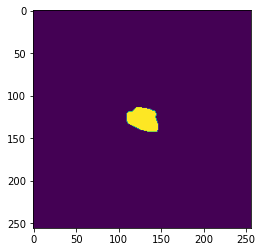

In [51]:
plt.imshow(true_img[0][2].to('cpu').detach())

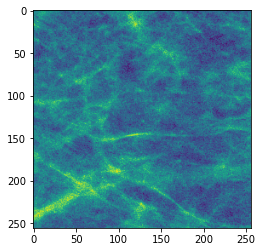

In [48]:
plt.imshow(input_img[0][0].to('cpu').detach())

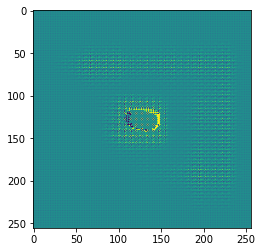

In [47]:
plt.imshow(test_out[0][0].to('cpu').detach())

In [43]:
discriminator(input_img)

tensor([[[[0.9900, 0.9943, 0.9951,  ..., 0.9954, 0.9951, 0.9870],
          [0.9948, 0.9968, 0.9975,  ..., 0.9977, 0.9975, 0.9947],
          [0.9955, 0.9968, 0.9975,  ..., 0.9977, 0.9976, 0.9951],
          ...,
          [0.9954, 0.9969, 0.9976,  ..., 0.9978, 0.9976, 0.9954],
          [0.9945, 0.9966, 0.9974,  ..., 0.9976, 0.9975, 0.9949],
          [0.9891, 0.9938, 0.9952,  ..., 0.9952, 0.9949, 0.9897]]],


        [[[0.9900, 0.9943, 0.9951,  ..., 0.9954, 0.9951, 0.9870],
          [0.9948, 0.9968, 0.9975,  ..., 0.9977, 0.9975, 0.9947],
          [0.9955, 0.9968, 0.9975,  ..., 0.9977, 0.9976, 0.9952],
          ...,
          [0.9954, 0.9969, 0.9976,  ..., 0.9978, 0.9976, 0.9954],
          [0.9945, 0.9966, 0.9974,  ..., 0.9976, 0.9975, 0.9949],
          [0.9891, 0.9938, 0.9952,  ..., 0.9953, 0.9949, 0.9897]]],


        [[[0.9900, 0.9943, 0.9951,  ..., 0.9954, 0.9951, 0.9870],
          [0.9948, 0.9968, 0.9975,  ..., 0.9977, 0.9975, 0.9947],
          [0.9955, 0.9968, 0.9975,  ..

In [44]:
discriminator(true_img)

tensor([[[[0.9822, 0.9895, 0.9909,  ..., 0.9912, 0.9907, 0.9775],
          [0.9903, 0.9941, 0.9952,  ..., 0.9955, 0.9951, 0.9901],
          [0.9914, 0.9942, 0.9953,  ..., 0.9955, 0.9953, 0.9908],
          ...,
          [0.9914, 0.9944, 0.9955,  ..., 0.9958, 0.9955, 0.9912],
          [0.9901, 0.9940, 0.9952,  ..., 0.9955, 0.9953, 0.9904],
          [0.9808, 0.9887, 0.9909,  ..., 0.9910, 0.9904, 0.9816]]],


        [[[0.9822, 0.9895, 0.9909,  ..., 0.9912, 0.9907, 0.9775],
          [0.9903, 0.9941, 0.9952,  ..., 0.9955, 0.9951, 0.9901],
          [0.9914, 0.9942, 0.9953,  ..., 0.9955, 0.9953, 0.9908],
          ...,
          [0.9914, 0.9944, 0.9955,  ..., 0.9958, 0.9955, 0.9912],
          [0.9901, 0.9940, 0.9952,  ..., 0.9955, 0.9953, 0.9904],
          [0.9808, 0.9887, 0.9909,  ..., 0.9910, 0.9904, 0.9816]]],


        [[[0.9822, 0.9895, 0.9909,  ..., 0.9912, 0.9907, 0.9775],
          [0.9903, 0.9941, 0.9952,  ..., 0.9955, 0.9951, 0.9901],
          [0.9914, 0.9942, 0.9953,  ..

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
b_tensor = torch.stack([image.to(device) for image in b], dim=0)

In [107]:
b_tensor.shape

NameError: name 'b_tensor' is not defined

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

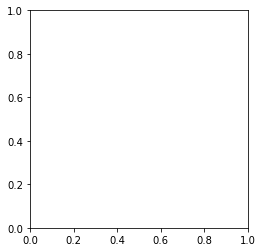

In [108]:
plt.imshow(generated_image[1,1])